## 1. FFHQ

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

from unet import UNetModel
from attr_classifier import FaceAttrModel
from diffusion import GaussianDiffusion

import tqdm
import matplotlib.pyplot as plt

/usr/local/conda/envs/ddpm/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load DDPM model
device = torch.device('cuda:0')

diff_net = UNetModel(image_size=256, in_channels=3, out_channels=6, 
                     model_channels=256, num_res_blocks=2, channel_mult=(1, 1, 2, 2, 4, 4),
                     attention_resolutions=[32,16,8], num_head_channels=64, dropout=0.1, resblock_updown=True, use_scale_shift_norm=True).to(device)
diff_net.load_state_dict(torch.load('models/ffhq.pt'))
print('Loaded Diffusion Model')

Loaded Diffusion Model


Loss: 0.0001:   0%|          | 0/250 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


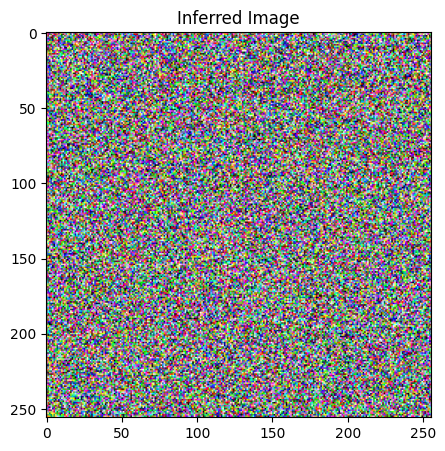

Loss: 0.0004:  10%|▉         | 24/250 [00:09<01:28,  2.56it/s]

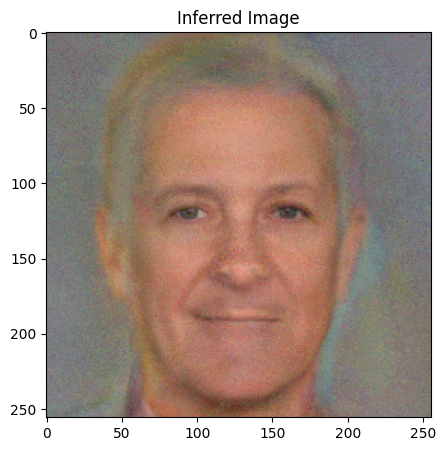

Loss: 0.0003:  20%|█▉        | 49/250 [00:19<01:18,  2.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


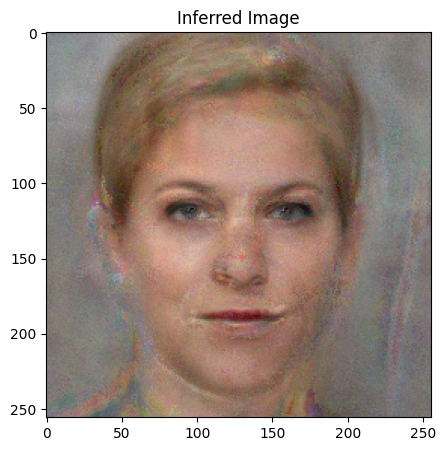

Loss: 0.0002:  30%|██▉       | 74/250 [00:29<01:08,  2.56it/s]

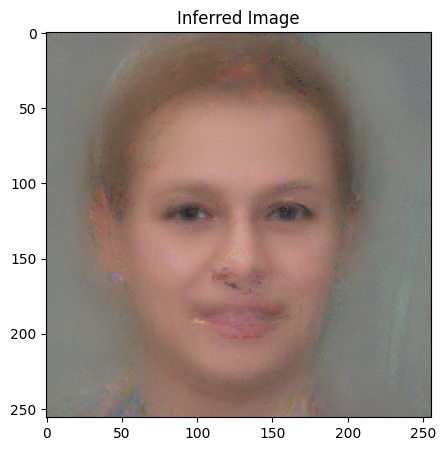

Loss: 0.0020:  40%|███▉      | 99/250 [00:39<00:58,  2.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


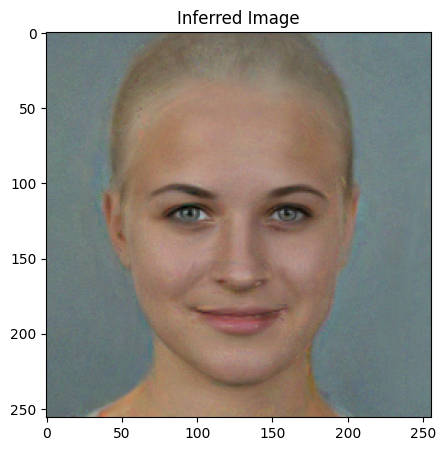

Loss: 0.0003:  50%|████▉     | 124/250 [00:49<00:49,  2.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


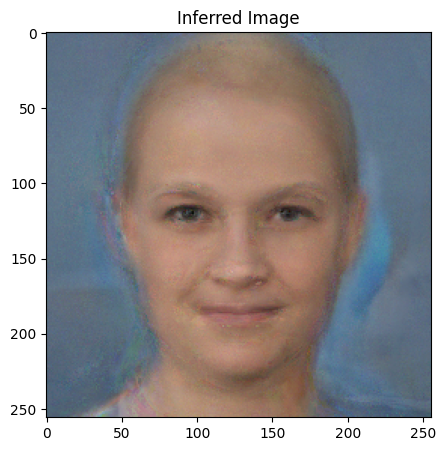

Loss: 0.0011:  60%|█████▉    | 149/250 [00:59<00:39,  2.56it/s]

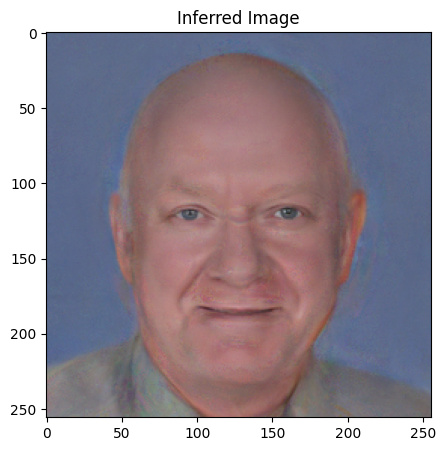

Loss: 0.0021:  70%|██████▉   | 174/250 [01:09<00:29,  2.56it/s]

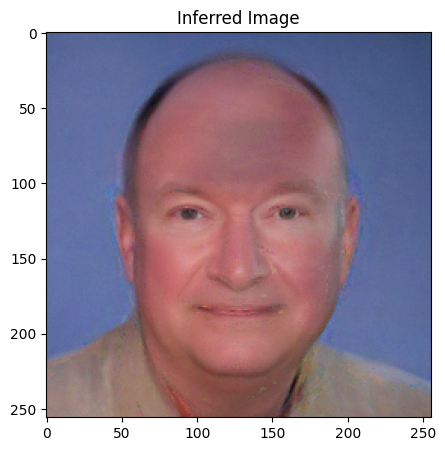

Loss: 0.0013:  80%|███████▉  | 199/250 [01:19<00:19,  2.56it/s]

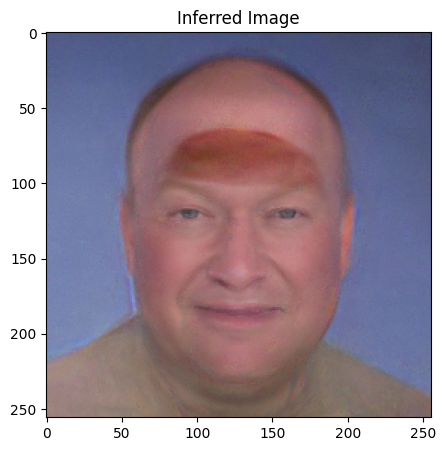

Loss: 0.0041:  90%|████████▉ | 224/250 [01:29<00:10,  2.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


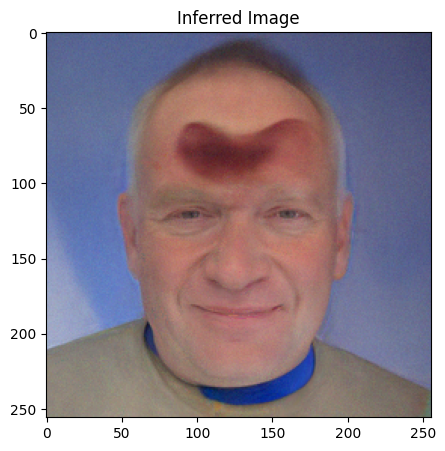

Loss: 0.0076: 100%|█████████▉| 249/250 [01:39<00:00,  2.56it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


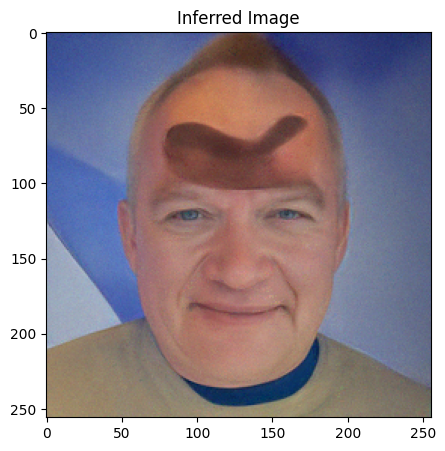

Loss: 0.0076: 100%|██████████| 250/250 [01:40<00:00,  2.49it/s]


In [4]:
X0 = torch.randn(1, 3, 256, 256).to(device) #初始化一个白噪声X0
X0.requires_grad_(True)
# Inference procedure steps
steps = 250   

opt = torch.optim.Adamax([X0], lr=1)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
diff_net.eval()

bar = tqdm.tqdm(range(steps))
for i, _ in enumerate(bar):
    # Select t      
    t = ((steps-i)/1.5 + (steps-i)/3*math.cos(i/10))/steps*800 + 200 # Linearly decreasing + cosine
    t = np.array([t + np.random.randint(-50, 51) for _ in range(1)]).astype(int) # Add noise to t
    t = np.clip(t, 1, diffusion.T)
       
    # Denoise
    sample_img = X0
    xt, epsilon = diffusion.sample(sample_img, t)       
    t = torch.from_numpy(t).float().view(1)    
    pred = diff_net(xt.float(), t.to(device))   
    epsilon_pred = pred[:,:3,:,:] # Use predicted noise only
    
    loss = F.mse_loss(epsilon_pred, epsilon)
    bar.set_description("Loss: {:.4f}".format(loss))

    opt.zero_grad()        
    loss.backward()

    with torch.no_grad():
        grad_norm = torch.linalg.norm(X0)
        if i > 0:
            alpha = 0.5
            norm_track = alpha*norm_track + (1-alpha)*grad_norm
        else:
            norm_track = grad_norm 
                  
    opt.step()

    if (i+1) % 25 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(10,5))
            ax.imshow(0.5*(X0+1)[0].cpu().numpy().transpose([1,2,0]))
            ax.set_title('Inferred Image')
            plt.show()

## 2. ImagNet uncond

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

from unet import UNetModel, EncoderUNetModel
from attr_classifier import FaceAttrModel
from diffusion import GaussianDiffusion

import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Load DDPM model
device = torch.device('cuda:0')

diff_net = UNetModel(image_size=256, in_channels=3, out_channels=6,
                     model_channels=256, num_res_blocks=2, channel_mult=(1, 1, 2, 2, 4, 4),
                     attention_resolutions=[32,16,8], num_head_channels=64, dropout=0.0, resblock_updown=True, use_scale_shift_norm=True).to(device)
diff_net.load_state_dict(torch.load('/root/Desktop/diffusionclean/guided-diffusion/models/256x256_diffusion_uncond.pt'))
print('Loaded Diffusion Model')

In [ ]:
def create_classifier(
    image_size,
    classifier_use_fp16,
    classifier_width,
    classifier_depth,
    classifier_attention_resolutions,
    classifier_use_scale_shift_norm,
    classifier_resblock_updown,
    classifier_pool,
):
    if image_size == 512:
        channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
    elif image_size == 256:
        channel_mult = (1, 1, 2, 2, 4, 4)
    elif image_size == 128:
        channel_mult = (1, 1, 2, 3, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    for res in classifier_attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    return EncoderUNetModel(
        image_size=image_size,
        in_channels=3,
        model_channels=classifier_width,
        out_channels=1000,
        num_res_blocks=classifier_depth,
        attention_resolutions=tuple(attention_ds),
        channel_mult=channel_mult,
        use_fp16=classifier_use_fp16,
        num_head_channels=64,
        use_scale_shift_norm=classifier_use_scale_shift_norm,
        resblock_updown=classifier_resblock_updown,
        pool=classifier_pool,
    )

classifier = create_classifier(
    image_size=256, 
    classifier_use_fp16=False, classifier_width=128, classifier_depth=2,
    classifier_attention_resolutions="32,16,8",  # 16
    classifier_use_scale_shift_norm=True,  # False
    classifier_resblock_updown=True,  # False
    classifier_pool="attention"
).to(device)

classifier.load_state_dict(torch.load("/root/Desktop/diffusionclean/guided-diffusion/models/256x256_clean_classifier.pt"))

In [ ]:
class InferenceModel(nn.Module):
    def __init__(self):
        super(InferenceModel, self).__init__()
        # Inferred image
        self.img = nn.Parameter(torch.randn(1,3,256,256))
        self.img.requires_grad = True

    def encode(self):
        return self.img

X0 = InferenceModel().to(device)
# Inference procedure steps
steps = 250   

opt = torch.optim.Adamax(X0.parameters(), lr=1)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
diff_net.eval()

classes = torch.randint(low=0, high=1000, size=(1,), device=device)

bar = tqdm.tqdm(range(steps))
for i, _ in enumerate(bar):
    # Select t      
    t = ((steps-i)/1.5 + (steps-i)/3*math.cos(i/10))/steps*800 + 200 # Linearly decreasing + cosine
    t = np.array([t + np.random.randint(-50, 51) for _ in range(1)]).astype(int) # Add noise to t
    t = np.clip(t, 1, diffusion.T)
       
    # Denoise
    sample_img = X0.encode()
    xt, epsilon = diffusion.sample(sample_img, t)       
    t = torch.from_numpy(t).float().view(1)    
    pred = diff_net(xt.float(), t.to(device))   
    epsilon_pred = pred[:,:3,:,:] # Use predicted noise only
    
    loss = F.mse_loss(epsilon_pred, epsilon)
    bar.set_description("Loss: {:.4f}".format(loss))

    opt.zero_grad()        
    loss.backward()

    with torch.no_grad():
        grad_norm = torch.linalg.norm(X0.img.grad)
        if i > 0:
            alpha = 0.5
            norm_track = alpha*norm_track + (1-alpha)*grad_norm
        else:
            norm_track = grad_norm 
                  
    opt.step()

    zero_t = torch.zeros((1,), device=device)
    logits = classifier(X0.encode(), zero_t)
    log_probs = F.log_softmax(logits, dim=-1)
    selected = log_probs[range(len(logits)), classes.view(-1)] 
    Loss_label = selected.sum()

    opt.zero_grad()
    Loss_label.backward()
    torch.nn.utils.clip_grad_norm_(X0.parameters(), 0.1*norm_track)
    opt.step()
    

    if (i+1) % 25 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(10,5))
            ax.imshow(0.5*(X0.encode()+1)[0].cpu().numpy().transpose([1,2,0]))
            ax.set_title('Inferred Image')
            plt.show()

## 3. ImageNet + AdaGN

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import math

from unet import UNetModel, EncoderUNetModel
from attr_classifier import FaceAttrModel
from diffusion import GaussianDiffusion

import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Load DDPM model
device = torch.device('cuda:0')

diff_net = UNetModel(image_size=256, in_channels=3, out_channels=6, num_classes=1000,
                     model_channels=256, num_res_blocks=2, channel_mult=(1, 1, 2, 2, 4, 4),
                     attention_resolutions=[32,16,8], num_head_channels=64, dropout=0.0, resblock_updown=True, use_scale_shift_norm=True).to(device)
diff_net.load_state_dict(torch.load('/root/Desktop/diffusionclean/guided-diffusion/models/256x256_diffusion.pt'))
print('Loaded Diffusion Model')

In [ ]:
def create_classifier(
    image_size,
    classifier_use_fp16,
    classifier_width,
    classifier_depth,
    classifier_attention_resolutions,
    classifier_use_scale_shift_norm,
    classifier_resblock_updown,
    classifier_pool,
):
    if image_size == 512:
        channel_mult = (0.5, 1, 1, 2, 2, 4, 4)
    elif image_size == 256:
        channel_mult = (1, 1, 2, 2, 4, 4)
    elif image_size == 128:
        channel_mult = (1, 1, 2, 3, 4)
    elif image_size == 64:
        channel_mult = (1, 2, 3, 4)
    else:
        raise ValueError(f"unsupported image size: {image_size}")

    attention_ds = []
    for res in classifier_attention_resolutions.split(","):
        attention_ds.append(image_size // int(res))

    return EncoderUNetModel(
        image_size=image_size,
        in_channels=3,
        model_channels=classifier_width,
        out_channels=1000,
        num_res_blocks=classifier_depth,
        attention_resolutions=tuple(attention_ds),
        channel_mult=channel_mult,
        use_fp16=classifier_use_fp16,
        num_head_channels=64,
        use_scale_shift_norm=classifier_use_scale_shift_norm,
        resblock_updown=classifier_resblock_updown,
        pool=classifier_pool,
    )

classifier = create_classifier(
    image_size=256, 
    classifier_use_fp16=False, classifier_width=128, classifier_depth=2,
    classifier_attention_resolutions="32,16,8",  # 16
    classifier_use_scale_shift_norm=True,  # False
    classifier_resblock_updown=True,  # False
    classifier_pool="attention"
).to(device)

classifier.load_state_dict(torch.load("/root/Desktop/diffusionclean/guided-diffusion/models/256x256_clean_classifier.pt"))

In [ ]:
class InferenceModel(nn.Module):
    def __init__(self):
        super(InferenceModel, self).__init__()
        # Inferred image
        self.img = nn.Parameter(torch.randn(1,3,256,256))
        self.img.requires_grad = True

    def encode(self):
        return self.img

X0 = InferenceModel().to(device)
# Inference procedure steps
steps = 250   

opt = torch.optim.Adamax(X0.parameters(), lr=1)

diffusion = GaussianDiffusion(T=1000, schedule='linear')
diff_net.eval()

classes = torch.randint(low=0, high=1, size=(1,), device=device)

bar = tqdm.tqdm(range(steps))
for i, _ in enumerate(bar):
    # Select t      
    t = ((steps-i)/1.5 + (steps-i)/3*math.cos(i/10))/steps*800 + 200 # Linearly decreasing + cosine
    t = np.array([t + np.random.randint(-50, 51) for _ in range(1)]).astype(int) # Add noise to t
    t = np.clip(t, 1, diffusion.T)
       
    # Denoise
    sample_img = X0.encode()
    xt, epsilon = diffusion.sample(sample_img, t)       
    t = torch.from_numpy(t).float().view(1)    
    pred = diff_net(xt.float(), t.to(device), y=classes.to(device))   
    epsilon_pred = pred[:,:3,:,:] # Use predicted noise only
    
    loss = F.mse_loss(epsilon_pred, epsilon)
    bar.set_description("Loss: {:.4f}".format(loss))

    opt.zero_grad()        
    loss.backward()

    with torch.no_grad():
        grad_norm = torch.linalg.norm(X0.img.grad)
        if i > 0:
            alpha = 0.5
            norm_track = alpha*norm_track + (1-alpha)*grad_norm
        else:
            norm_track = grad_norm 
                  
    opt.step()

    zero_t = torch.zeros((1,), device=device)
    logits = classifier(X0.encode(), zero_t)
    log_probs = F.log_softmax(logits, dim=-1)
    selected = log_probs[range(len(logits)), classes.view(-1)] 
    Loss_label = selected.sum()

    opt.zero_grad()
    Loss_label.backward()
    torch.nn.utils.clip_grad_norm_(X0.parameters(), 0.1*norm_track)
    opt.step()
    

    if (i+1) % 25 == 0 or i == 0:
        with torch.no_grad():
            fig, ax = plt.subplots(1, 1, figsize=(10,5))
            ax.imshow(0.5*(X0.encode()+1)[0].cpu().numpy().transpose([1,2,0]))
            ax.set_title('Inferred Image')
            plt.show()